In [1]:
# ==============================================================================
# 1. CONFIGURAÇÃO INICIAL E BIBLIOTECAS
# ==============================================================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import warnings

# Configurações de visualização
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')


In [2]:
def bcb_get(codigo, nome_coluna, inicio, fim):
    """
    Busca uma série temporal da API do Banco Central do Brasil (BCB).

    Args:
        codigo (int): O código da série no sistema SGS do BCB.
        nome_coluna (str): Nome para a coluna no DataFrame resultante.
        inicio (str): Data de início no formato 'YYYY-MM-DD'.
        fim (str): Data de fim no formato 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: DataFrame com a série temporal.
    """
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados?formato=json&dataInicial={inicio.split("-")[2]}/{inicio.split("-")[1]}/{inicio.split("-")[0]}&dataFinal={fim.split("-")[2]}/{fim.split("-")[1]}/{fim.split("-")[0]}'
    try:
        df = pd.read_json(url)
        df['data'] = pd.to_datetime(df['data'], dayfirst=True)
        df.set_index('data', inplace=True)
        df.rename(columns={'valor': nome_coluna}, inplace=True)
        # A SELIC vem como % ao dia, então anualizamos (aproximadamente)
        if nome_coluna == 'SELIC':
             df[nome_coluna] = (1 + df[nome_coluna]/100)**252 - 1
             df[nome_coluna] = df[nome_coluna] * 100
        return df
    except Exception as e:
        print(f"Erro ao buscar dados para o código {codigo}: {e}")
        return pd.DataFrame()



[*********************100%***********************]  2 of 2 completed


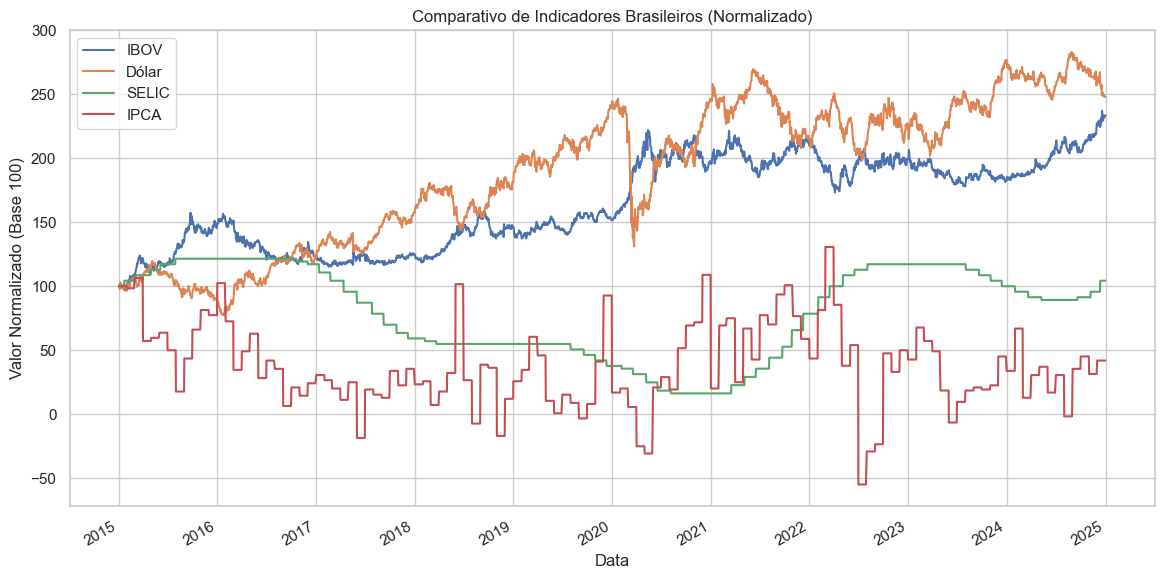

In [6]:
# Definindo o período
start_date = "2015-01-01"
end_date = "2024-12-31" # Usando data atual como fim para dados disponíveis

# Tickers para Yahoo Finance
tickers_yf = ['^BVSP', 'USDBRL=X']

# Códigos para o Banco Central
# 11: SELIC | 433: IPCA
selic_code = 11
ipca_code = 433

# Buscando dados do Yahoo Finance
data_yf = yf.download(tickers_yf, start=start_date, end=end_date)['Close']
data_yf.rename(columns={'^BVSP': 'IBOV', 'USDBRL=X': 'Dolar'}, inplace=True)

# Buscando dados do BCB
selic_data = bcb_get(selic_code, 'SELIC', start_date, end_date)
ipca_data = bcb_get(ipca_code, 'IPCA', start_date, end_date)

# Combinando todos os dados em um único DataFrame
df_q1 = data_yf.join(selic_data, how='outer').join(ipca_data, how='outer')

# Preenchendo valores ausentes (SELIC e IPCA são diários e mensais, respectivamente)
df_q1.fillna(method='ffill', inplace=True)
df_q1.dropna(inplace=True)

# Normalizando os dados para permitir comparação visual
df_q1_normalized = (df_q1 / df_q1.iloc[0]) * 100

# Plotando o gráfico
df_q1_normalized.plot(figsize=(14, 7), title='Comparativo de Indicadores Brasileiros (Normalizado)')
plt.ylabel('Valor Normalizado (Base 100)')
plt.xlabel('Data')
plt.legend(['IBOV', 'Dólar', 'SELIC', 'IPCA'])
plt.grid(True)
plt.show()


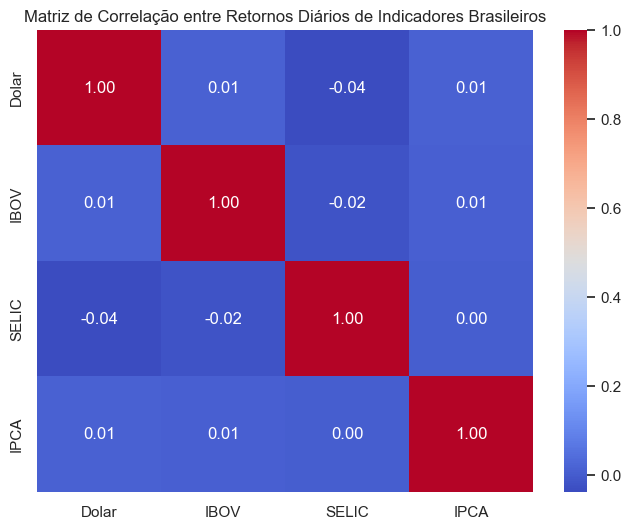

In [4]:
# Calculando os retornos diários para análise de correlação
returns_q1 = df_q1.pct_change().dropna()

# Construindo a matriz de correlação
correlation_matrix = returns_q1.corr()

# Plotando o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Retornos Diários de Indicadores Brasileiros')
plt.show()


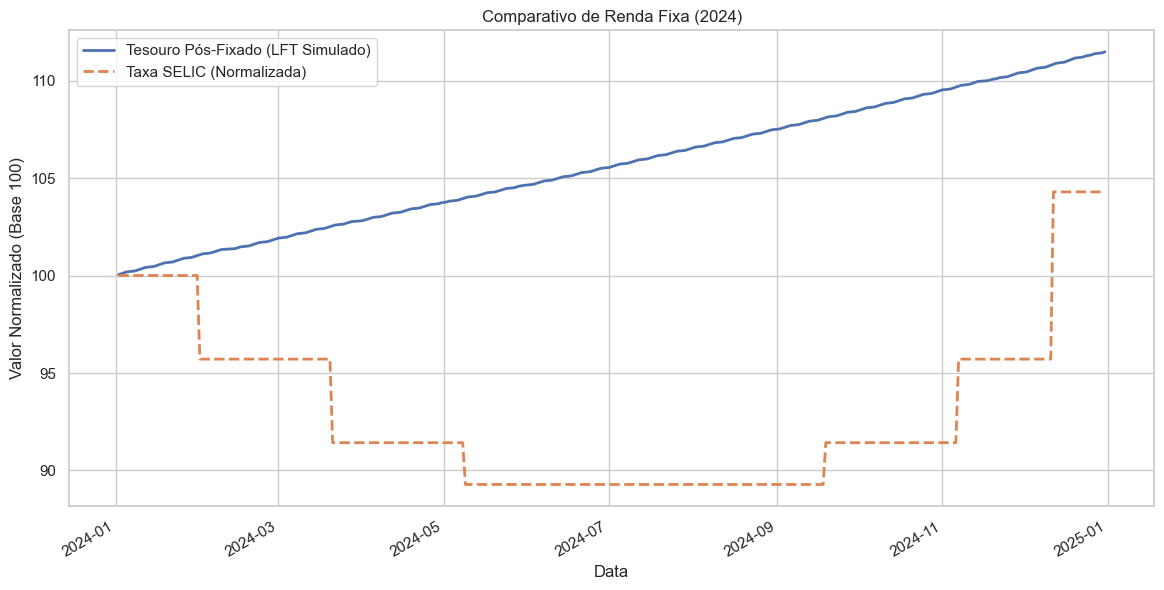

In [ ]:
# Período
start_rf = '2024-01-01'
end_rf = '2024-12-31'

# Buscar dados da SELIC
selic_rf = bcb_get(selic_code, 'SELIC', start_rf, end_rf)

# Simulação do Tesouro Pós-Fixado (Tesouro Selic / LFT)
# O retorno diário é a taxa SELIC diária.
daily_selic_rate = (selic_rf['SELIC'] / 100) / 252
tesouro_pos = (1 + daily_selic_rate).cumprod() * 100
tesouro_pos.name = 'Tesouro Pós-Fixado (Simulado)'

# Plotando
fig, ax = plt.subplots(figsize=(14, 7))
tesouro_pos.plot(ax=ax, label='Tesouro Pós-Fixado (LFT Simulado)', lw=2)
(selic_rf['SELIC'] / selic_rf['SELIC'].iloc[0] * 100).plot(ax=ax, label='Taxa SELIC (Normalizada)', linestyle='--', lw=2)

plt.title('Comparativo de Renda Fixa (2024)')
plt.ylabel('Valor Normalizado (Base 100)')
plt.xlabel('Data')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


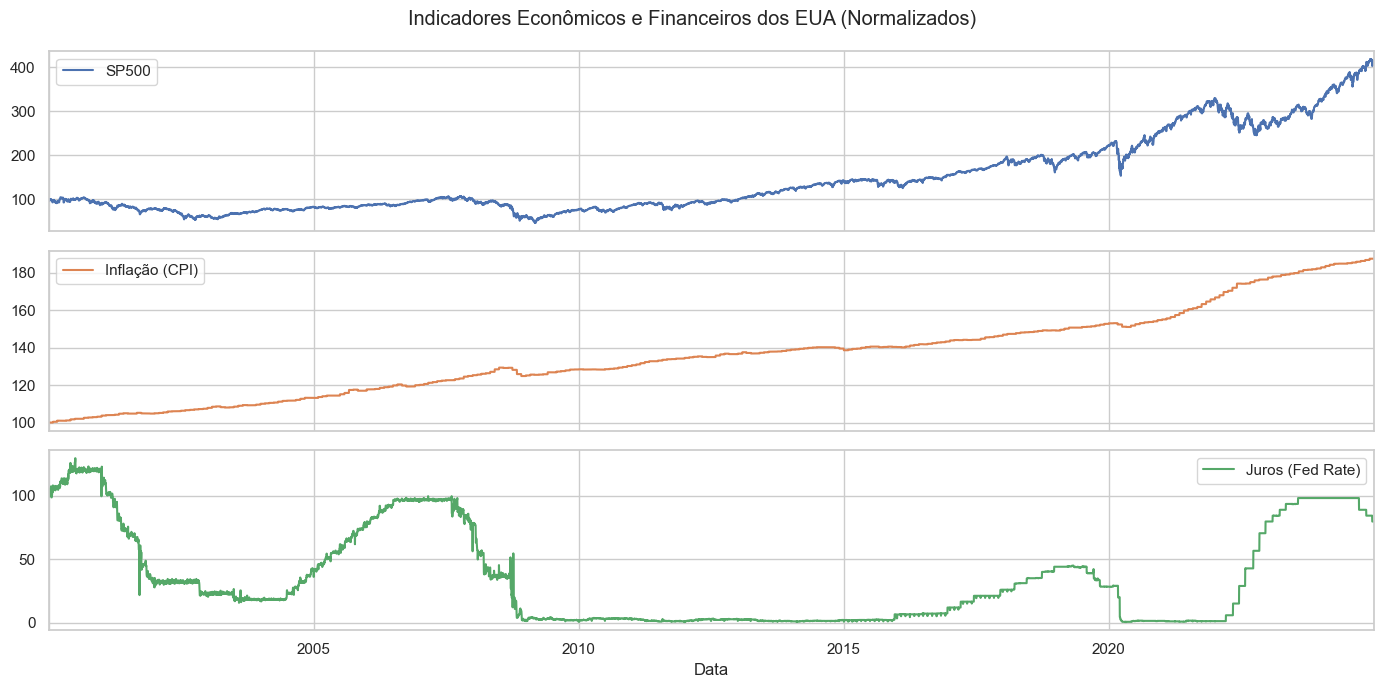

In [11]:
# Período
start_us = '2000-01-01'
end_us = '2024-12-31'

# Tickers para FRED (Federal Reserve Economic Data)
fred_tickers = ['CPIAUCSL', 'DFF']

# Buscando dados
sp500_data = yf.download('^GSPC', start=start_us, end=end_us)
sp500 = sp500_data[['Close']] 
sp500.columns = ['SP500']

us_econ_data = web.get_data_fred(fred_tickers, start=start_us, end=end_us)
us_econ_data.rename(columns={'CPIAUCSL': 'Inflação (CPI)', 'DFF': 'Juros (Fed Rate)'}, inplace=True)

# Combinando e tratando dados
df_q4 = sp500.join(us_econ_data, how='outer').fillna(method='ffill').dropna()

# Normalizando
df_q4_normalized = (df_q4 / df_q4.iloc[0]) * 100

# Plotando
df_q4_normalized.plot(figsize=(14, 7), subplots=True, layout=(3, 1),
                      title='Indicadores Econômicos e Financeiros dos EUA (Normalizados)')
plt.xlabel('Data')
plt.tight_layout()
plt.show()


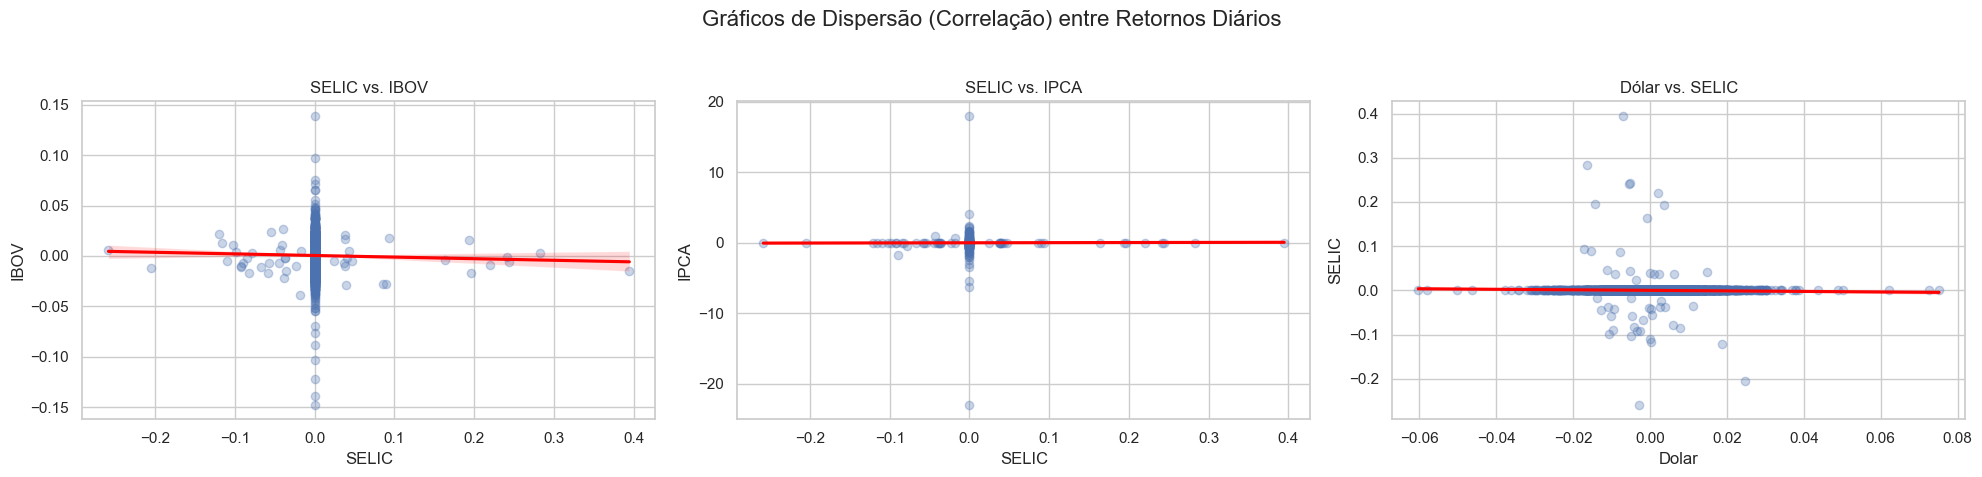

In [12]:
# Usando os retornos diários da Questão 2
# Lembre-se que IPCA e SELIC têm baixa volatilidade diária.

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Gráficos de Dispersão (Correlação) entre Retornos Diários', fontsize=16)

# 1. SELIC x IBOV
sns.regplot(x=returns_q1['SELIC'], y=returns_q1['IBOV'], ax=axes[0],
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
axes[0].set_title('SELIC vs. IBOV')

# 2. SELIC x IPCA
sns.regplot(x=returns_q1['SELIC'], y=returns_q1['IPCA'], ax=axes[1],
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
axes[1].set_title('SELIC vs. IPCA')

# 3. Dólar x SELIC
sns.regplot(x=returns_q1['Dolar'], y=returns_q1['SELIC'], ax=axes[2],
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
axes[2].set_title('Dólar vs. SELIC')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()